In [34]:
# Assignment1
# Author: David Bui
# DSC-540
# Date: 11/3/2021
# Description: This is an overview of real estate prices and prediciton based on 15 variables that were selected
#    based off of correlation. This model can predict both current and future real estate prices. The database
#    is from a competitive event on real estate sale prediciton. 
#    https://www.kaggle.com/c/house-prices-advanced-regression-techniques

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

# the test dataframe does not contain sale price, since these are what we are predicting and is the reason why
#    I split the training set to perform evaluations before predicting the test set to utlize the best model.
train = pd.read_csv(r'C:\Users\David\OneDrive\Desktop\GCU Studies\DSC-540\Topic 1\Assignment\Data\train.csv')
test = pd.read_csv(r'C:\Users\David\OneDrive\Desktop\GCU Studies\DSC-540\Topic 1\Assignment\Data\test.csv')

C:\Users\David\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 178871.34 and sigma = 77005.49



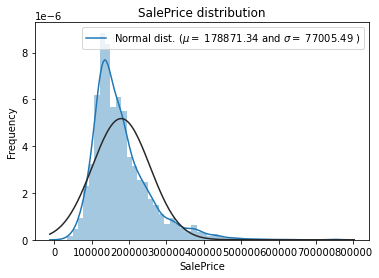

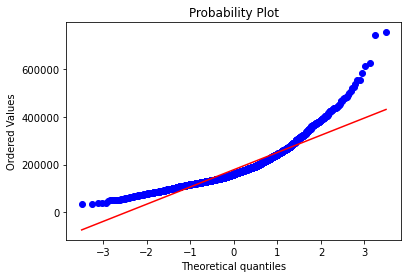

In [35]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() 

In [36]:
corr = train.corr()
corr[corr['SalePrice']>0.3].index

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [37]:
train = train[['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice']]

In [38]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#dealing with missing data
train = train.drop(['LotFrontage'],axis = 1)
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
train['MasVnrArea'] = train['MasVnrArea'].fillna(train['MasVnrArea'].mean())
train['GarageCars'] = train['GarageCars'].fillna(train['GarageCars'].mean())
train['GarageArea'] = train['GarageArea'].fillna(train['GarageArea'].mean())
train['BsmtFinSF1'] = train['BsmtFinSF1'].fillna(train['BsmtFinSF1'].mean())
train['TotalBsmtSF'] = train['TotalBsmtSF'].fillna(train['TotalBsmtSF'].mean())

In [39]:
train.head()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,7,2003,2003,196.0,706.0,856.0,856,854,1710,2,8,0,2003.0,2.0,548.0,0,61,208500.0
1,6,1976,1976,0.0,978.0,1262.0,1262,0,1262,2,6,1,1976.0,2.0,460.0,298,0,181500.0
2,7,2001,2002,162.0,486.0,920.0,920,866,1786,2,6,1,2001.0,2.0,608.0,0,42,223500.0
3,7,1915,1970,0.0,216.0,756.0,961,756,1717,1,7,1,1998.0,3.0,642.0,0,35,140000.0
4,8,2000,2000,350.0,655.0,1145.0,1145,1053,2198,2,9,1,2000.0,3.0,836.0,192,84,250000.0


In [40]:
cols = corr.nlargest(15, 'SalePrice')['SalePrice'].index
train = train[cols]

# Here I am splitting the training set into training and test sets, again since test doesn't hold actual Y values.
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.3, random_state=101)

# we are going to scale to data
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

X_train = sm.add_constant(X_train) # The book instructed us to add a constant.
X_test = sm.add_constant(X_test)

# Here I perform a 4 model comparison that will provide an evaluation via error rate according to what the assignment asks.

# Linear Regression Model
model = sm.OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     884.8
Date:                Sat, 06 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:40:46   Log-Likelihood:                -895.52
No. Observations:                2043   AIC:                             1821.
Df Residuals:                    2028   BIC:                             1905.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.631e-16      0.008   1.96e-14      1.000      -0.016       0.016
x1             0.2910      0.014     20.238      0.000       0.263       0.319
x2             0.3315      0.019     17.200      0.000       0.294       0.369
x3             0.0668      0.020      3.370      0.001       0.028       0.106
x4             0.0599      0.019      3.132      0.002       0.022       0.097
x5             0.1390      0.016      8.775      0.000       0.108       0.170
x6            -0.0048      0.016     -0.309      0.758      -0.035       0.026
x7            -0.0039      0.013     -0.305      0.760      -0.029       0.021
x8             0.0647      0.016      4.152      0.000       0.034       0.095
x9             0.0851      0.012      7.230      0.000       0.062       0.108
x10            0.0148      0.015      1.016      0.310      -0.014       0.043
x11            0.0075      0.015      0.496      0.620      -0.022       0.037
x12            0.0419      0.010      4.270      0.000       0.023       0.061
x13            0.0633      0.010      6.253      0.000       0.043       0.083
x14            0.1289      0.010     12.703      0.000       0.109       0.149
==============================================================================
Omnibus:                      683.060   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49966.059
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                      27.190   Cond. No.                         8.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
predictions = results.predict(X_test)
predictions = predictions.reshape(-1,1)

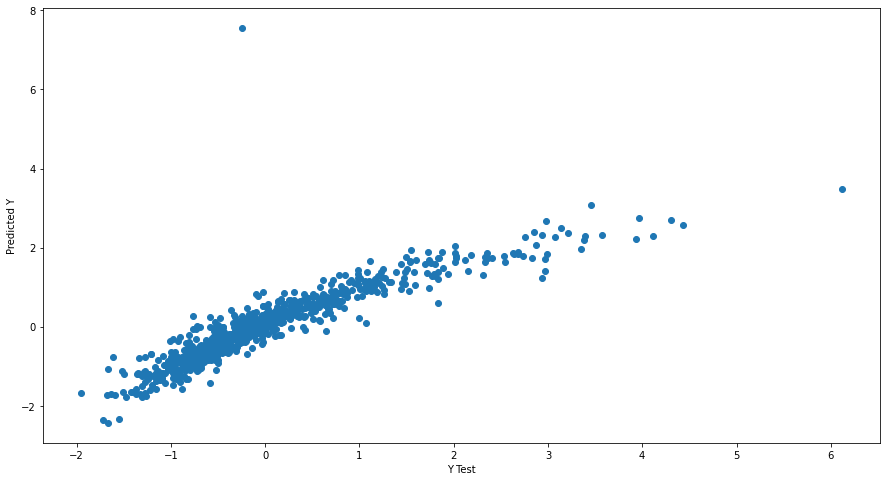

In [42]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.24448284464272027
MSE: 0.1927427426332457
RMSE: 0.43902476312076716


In [44]:
# Gradient Boosting Regression
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
clf.score(X_train, y_train)

C:\Users\David\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9657356941897699

In [45]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

In [46]:
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))

MAE: 0.18557540384502783
MSE: 0.0853888288323452
RMSE: 0.2922136698245741


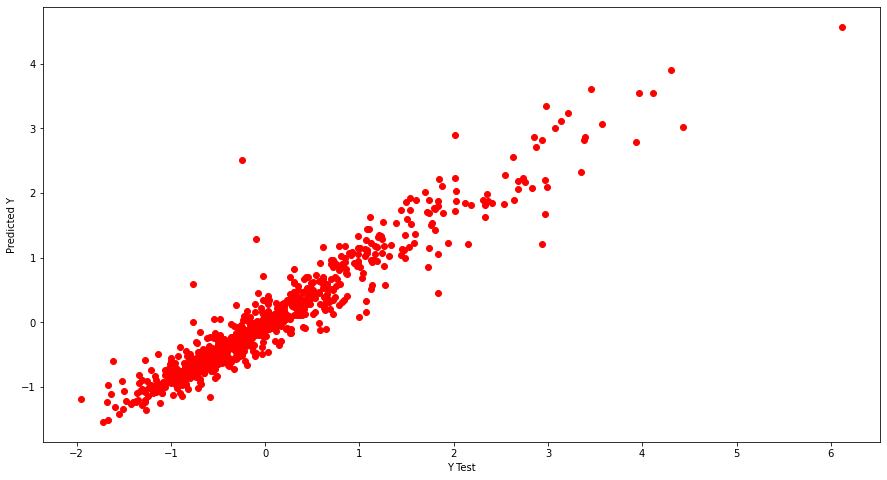

In [47]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [48]:
# Decision Tree Regression
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [49]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

#tree.plot_tree(dtreg,
 #       feature_names=X_train,  
  #      class_names=y_train,
   #     filled = True);

In [50]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

MAE: 0.29784723231052435
MSE: 0.20797387301582354
RMSE: 0.45604152553887406


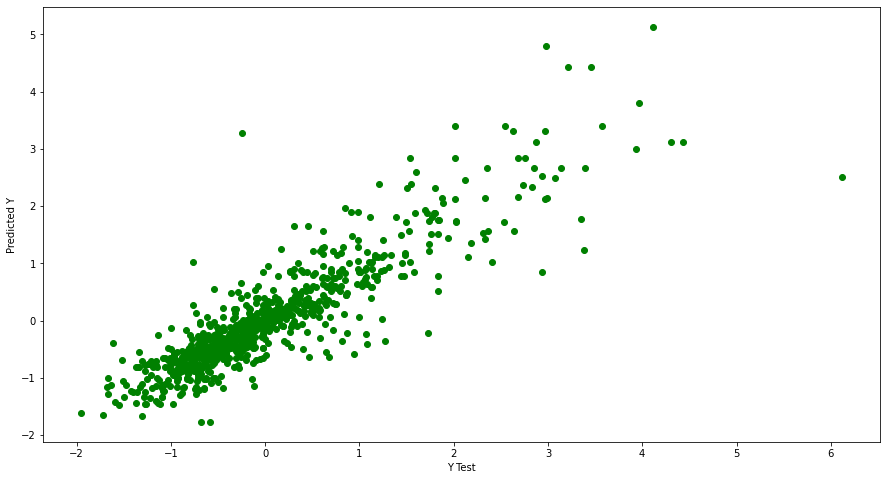

In [51]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [52]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)

<ipython-input-52-664918805d82>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


RandomForestRegressor(random_state=0)

In [53]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [54]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))

MAE: 0.19525988582960477
MSE: 0.09632388239141218
RMSE: 0.31036089056356986


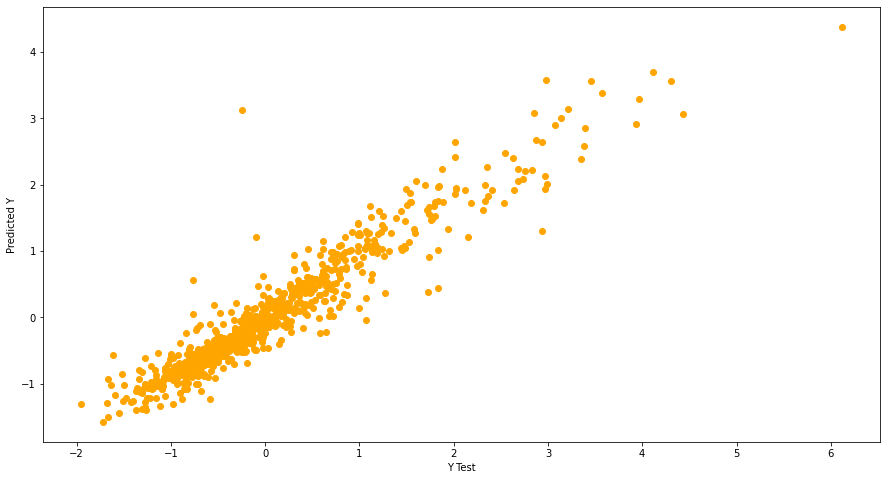

In [55]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [56]:
error_rate=np.array([metrics.mean_squared_error(y_test, predictions),metrics.mean_squared_error(y_test, clf_pred),metrics.mean_squared_error(y_test, dtr_pred),metrics.mean_squared_error(y_test, rfr_pred)])
print("  LM         GBR        DTR        RFR\n",error_rate)

  LM         GBR        DTR        RFR
 [0.19274274 0.08538883 0.20797387 0.09632388]


In [ ]:
# Out of the 4 models the Gradient Boosting Regression holds the lowest error rates in all categories. Making it the best model
# for our test predictions of current and future sale price.